# Pill 6- Overfitting

<div class = "alert alert-danger" style = "border-radius:10px">**DEPENDENCIES:** `ipywidgets` dependency.</div>

In the last lecture we saw that the process of learning consists of finding the model such that 

$$E_{out}\rightarrow 0$$

This problem can not directly be addressed. For this reason in order to achieve this we decompose it in two different processes.

Because we have data we can operate upon, we can use a proxy of the out-of-sample error, the empirical or in-sample error $E_{in}$. 

Thus, we would like two conditions

$$E_{in} \rightarrow 0$$

but also that 

$$E_{out}\approx E_{in}$$.

The first condition is achieved by selecting an optimization/learning method that minimizes $E_{in}$ or a surrogate function. The second condition is met when we consider the probabilistic setting and derive bounds by means of Hoeffding's inequality and variants. 

In that sense, we saw that

$$E_{out}\leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$
where $C$ is a notion of complexity and $N$ the amount of data samples.

Let us practice a little with these notions and observe the consequences.

Let me define a polynomial using Chebyshev's polynomial basis.

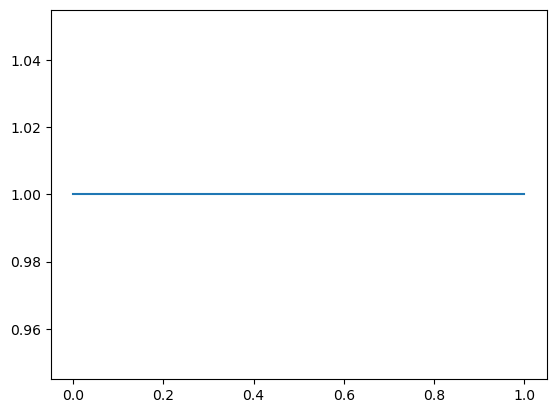

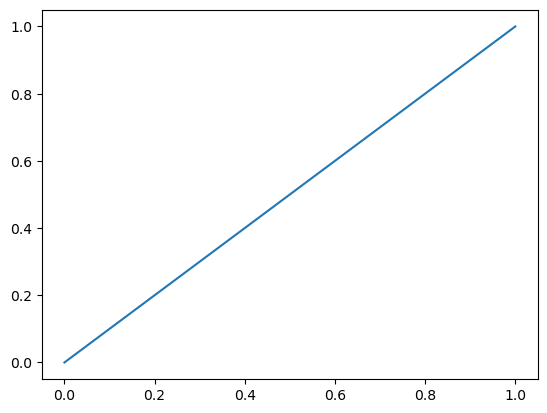

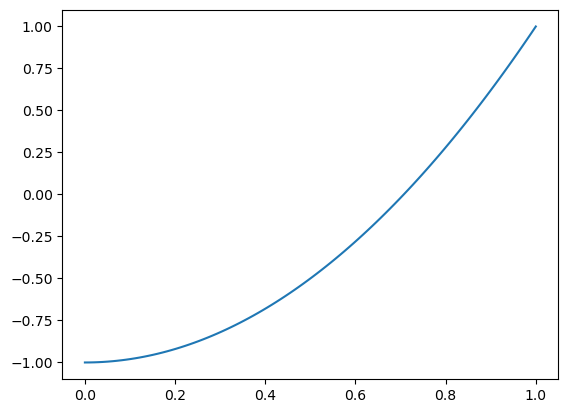

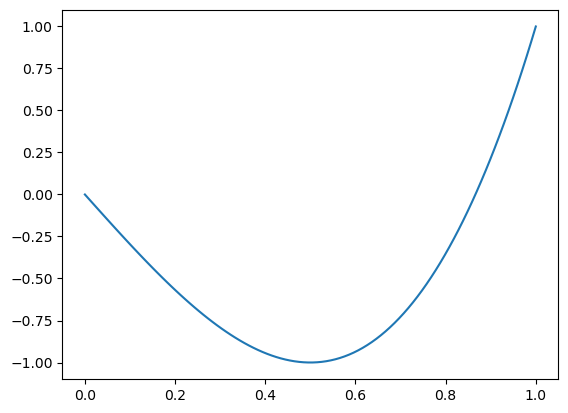

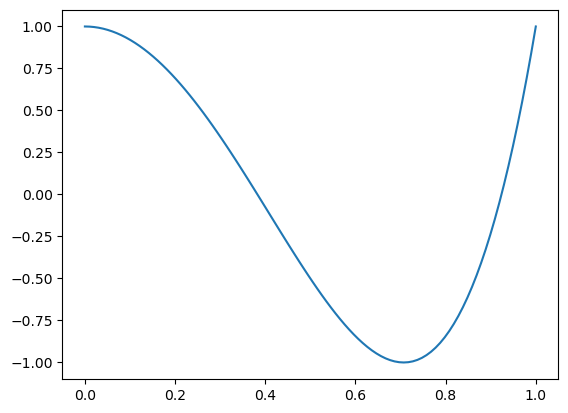

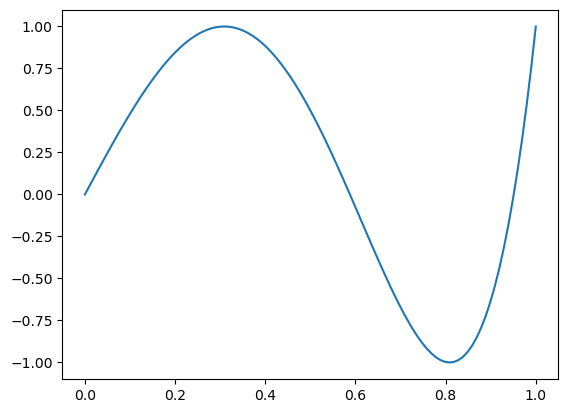

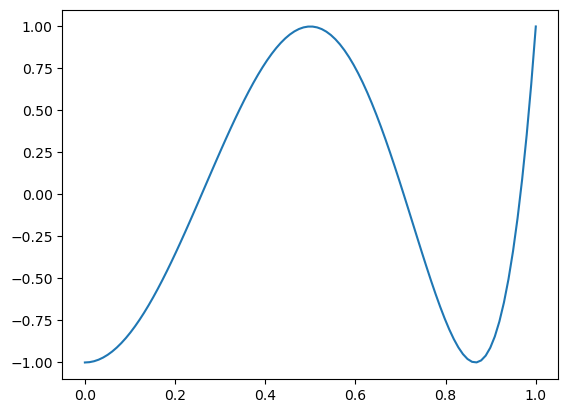

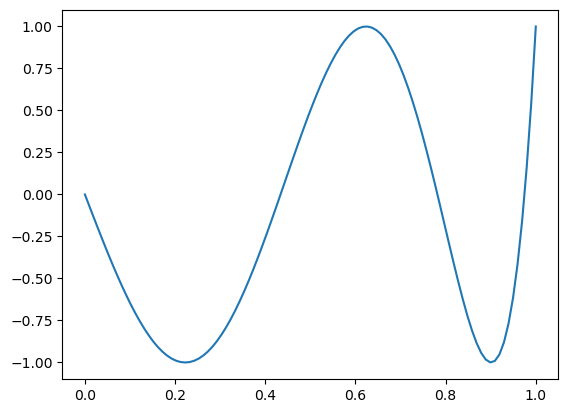

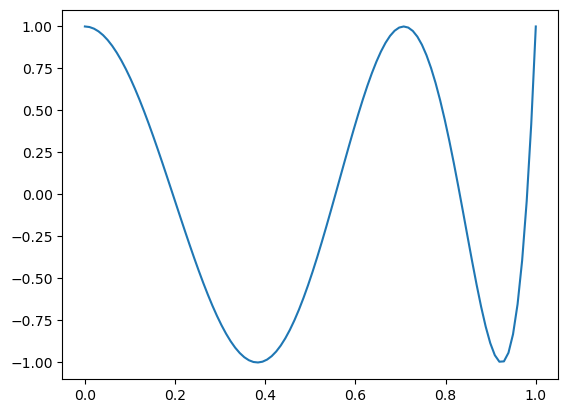

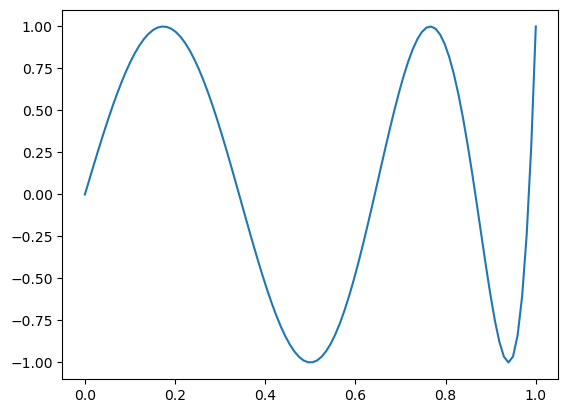

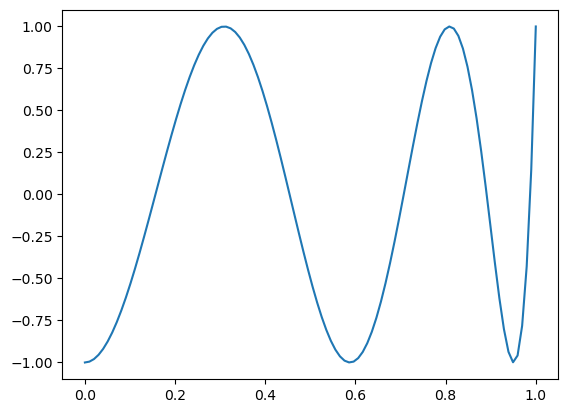

In [1]:
import numpy as np

def polyval(coefs, x):
    res = coefs[0]*np.ones((1,x.shape[0]))
    for i in range(1,len(coefs)):
        res = res + coefs[i]*np.power(x,i)
    return res
        

def chebys (coefs, x):
    pol = {}
    pol[0] = [1][::-1]
    pol[1] = [1, 0][::-1]
    pol[2] = [2, 0, -1][::-1]
    pol[3] = [4, 0, -3, 0][::-1]
    pol[4] = [8, 0, -8, 0, 1][::-1]
    pol[5] = [16, 0, -20, 0, 5, 0][::-1]
    pol[6] = [32, 0, -48, 0, 18, 0, -1][::-1]
    pol[7] = [64, 0, -112, 0, 56, 0, -7, 0][::-1]
    pol[8] = [128, 0, -256, 0, 160, 0, -32, 0, 1][::-1]
    pol[9] = [256, 0, -576, 0, 432, 0, -120, 0, 9, 0][::-1]
    pol[10] = [512, 0, -1280, 0, 1120, 0, -400, 0, 50, 0, -1][::-1]
    pol[11] = [1024, 0, -2816, 0, 2816, 0, -1232, 0, 220, 0, -11, 0][::-1]

    res = np.zeros((1,x.shape[0]))

    for i in range(len(coefs)):
        res= res + coefs[i]*polyval(pol[i],x)
    return res

        
x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt

for i in range(11):
    co = np.zeros((11,))
    co[i]=1.
    plt.figure()
    plt.plot(x,chebys(co,x).ravel())



Let us create a random polynomial and add some noise:

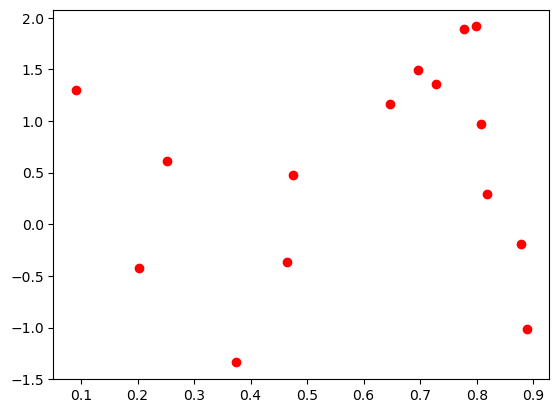

In [2]:
#Create a polynomial with noise
np.random.seed(0)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt
vals=chebys(coefs,x).ravel()
#plt.plot(x,vals)

N=15
idx = np.random.randint(0,100,N)
data = vals[idx]+0.5*np.random.normal(size=len(idx))

plt.plot(x[idx],data,'ro')

x_train = x[idx]
y_train = data

<div class = "alert alert-danger" style = "border-radius:10px">**QUIZ/EXERCISE** 
We have a data set that comes from a 10th order polynomial using Chebishev polynomial basis with some noise added. 

<ol>
<li>Fit a tenth order polynomial using what you know about linear regression and interaction features. **HINT:** Remember that for each sample you can create the powers of the value up to order 10 and then use that to fit a linear model.</li>
<li>Compute the in-sample root mean squared error of the fit.</li>
<li>Compute an approximation of the out of sample root mean squared error by using 100 uniform out of samples.</li>
</ol>
<p>
**HINT:** Use a preconditioner of 1e-6 in the matrix inversion. This is 

$$A^{-1} \approx (A+10^{-6}I)^{-1}$$

where $I$ is the identity matrix.

</div>

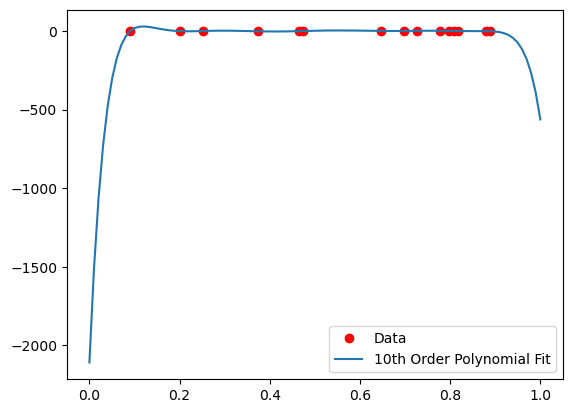

In-sample Root Mean Squared Error: 0.2224663826340472
Out-of-sample Root Mean Squared Error: 2.368234530720051


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Original data creation code
np.random.seed(0)
coefs = np.random.random(11)
x = np.linspace(0, 1, 100)
vals = chebys(coefs, x).ravel()
N = 15
idx = np.random.randint(0, 100, N)
data = vals[idx] + 0.5 * np.random.normal(size=len(idx))

# Create a design matrix with powers of x up to order 10
poly = PolynomialFeatures(degree=10)
X_train = poly.fit_transform(x[idx].reshape(-1, 1))

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, data)

# Generate predictions for the entire range of x
X_all = poly.transform(x.reshape(-1, 1))
y_pred = regression_model.predict(X_all)

# Plot the original data points and the fitted polynomial
plt.plot(x[idx], data, 'ro', label='Data')
plt.plot(x, y_pred, label='10th Order Polynomial Fit')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

# Compute predictions using the trained model
y_pred = regression_model.predict(X_train)

# Compute the mean squared error
mse = mean_squared_error(data, y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("In-sample Root Mean Squared Error:", rmse)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate 100 uniform out-of-sample data points
x_out_of_sample = np.linspace(0, 1, 100)

# Create a design matrix for out-of-sample points
X_out_of_sample = poly.transform(x_out_of_sample.reshape(-1, 1))

# Calculate predictions for out-of-sample data using preconditioned matrix inversion
A = np.dot(X_train.T, X_train)
preconditioner = 1e-6
A_inv = np.linalg.inv(A + preconditioner * np.identity(A.shape[0]))
w = np.dot(A_inv, np.dot(X_train.T, data))
y_out_of_sample = np.dot(X_out_of_sample, w)

# Calculate the RMSE for out-of-sample data
out_of_sample_data = chebys(coefs, x_out_of_sample).ravel()  # Actual data for out-of-sample points
out_of_sample_mse = mean_squared_error(out_of_sample_data, y_out_of_sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)

print("Out-of-sample Root Mean Squared Error:", out_of_sample_rmse)

<div class = "alert alert-danger" style = "border-radius:10px">**QUIZ** 
Repeat the former exercise for polynomial degrees 3. 
</div>

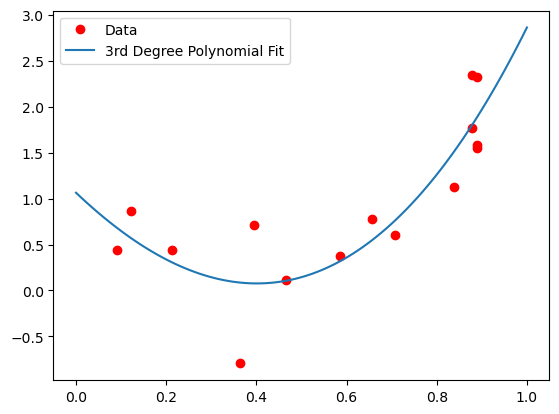

In-sample Root Mean Squared Error: 0.38816356940484387
Out-of-sample Root Mean Squared Error: 0.42575758683753534


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Original data creation code
np.random.seed(0)
coefs = np.random.random(4)  # Use 4 coefficients for a 3rd-degree polynomial
x = np.linspace(0, 1, 100)
vals = chebys(coefs, x).ravel()
N = 15
idx = np.random.randint(0, 100, N)
data = vals[idx] + 0.5 * np.random.normal(size=len(idx))

# Create a design matrix with powers of x up to degree 3
poly = PolynomialFeatures(degree=3)  # Change the degree to 3
X_train = poly.fit_transform(x[idx].reshape(-1, 1))

# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, data)

# Generate predictions for the entire range of x
X_all = poly.transform(x.reshape(-1, 1))
y_pred = regression_model.predict(X_all)

# Plot the original data points and the fitted polynomial
plt.plot(x[idx], data, 'ro', label='Data')
plt.plot(x, y_pred, label='3rd Degree Polynomial Fit')  # Update the label
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

# Compute predictions using the trained model
y_pred = regression_model.predict(X_train)

# Compute the mean squared error
mse = mean_squared_error(data, y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("In-sample Root Mean Squared Error:", rmse)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate 100 uniform out-of-sample data points
x_out_of_sample = np.linspace(0, 1, 100)

# Create a design matrix for out-of-sample points
X_out_of_sample = poly.transform(x_out_of_sample.reshape(-1, 1))

# Calculate predictions for out-of-sample data using preconditioned matrix inversion
A = np.dot(X_train.T, X_train)
preconditioner = 1e-6
A_inv = np.linalg.inv(A + preconditioner * np.identity(A.shape[0]))
w = np.dot(A_inv, np.dot(X_train.T, data))
y_out_of_sample = np.dot(X_out_of_sample, w)

# Calculate the RMSE for out-of-sample data
out_of_sample_data = chebys(coefs, x_out_of_sample).ravel()  # Actual data for out-of-sample points
out_of_sample_mse = mean_squared_error(out_of_sample_data, y_out_of_sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)

print("Out-of-sample Root Mean Squared Error:", out_of_sample_rmse)

# Fitting a polynomial without noise

Let us repeat the problem using without noise.

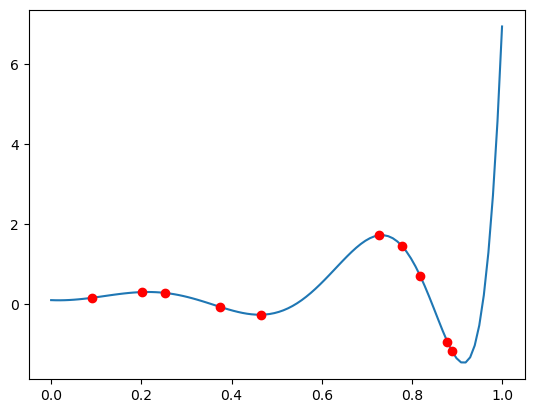

In [5]:
#Create a polynomial without noise
np.random.seed(0)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt
vals=chebys(coefs,x).ravel()
plt.plot(x,vals)

N=10
idx = np.random.randint(0,100,N)
data = vals[idx]

plt.plot(x[idx],data,'ro')

x_train = x[idx]
y_train = data

<div class = "alert alert-info" style = "border-radius:10px">**POLL:** 
We have the sample from a 10th-order polynomial and we know that the true generating function is a 10th-order polynomial and that we don't have noise. What model order should I use?
</div>

If you have a sample from a 10th-order polynomial, and you know that the true generating function is a 10th-order polynomial without noise, then the ideal model order to use is also a 10th-order polynomial. In this case, using a 10th-order polynomial model is appropriate because it perfectly represents the underlying data generation process, and there is no noise to account for.

Using a 10th-order polynomial model will allow your model to fit the data accurately and reproduce the true generating function without introducing any bias or underfitting. In summary, when you know that the true relationship is a 10th-order polynomial, and there is no noise, you should use a 10th-order polynomial model to achieve the best representation of the data.

<div class = "alert alert-danger" style = "border-radius:10px">**QUIZ/EXERCISE** 
We have the data set that comes from a 10th order polynomial using Chebishev polynomial basis without noise added. Compute the in-sample RMSE and out-of-sample RMSE for polynomial fits with degree 10 and 3.
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Original data creation code
np.random.seed(0)
coefs = np.random.random(11)
x = np.linspace(0, 1, 100)
vals = chebys(coefs, x).ravel()
N = 10
idx = np.random.randint(0, 100, N)
data = vals[idx]

# Create a design matrix with powers of x up to degree 10
poly_degree_10 = PolynomialFeatures(degree=10)
X_train_degree_10 = poly_degree_10.fit_transform(x[idx].reshape(-1, 1))

# Create a design matrix with powers of x up to degree 3
poly_degree_3 = PolynomialFeatures(degree=3)
X_train_degree_3 = poly_degree_3.fit_transform(x[idx].reshape(-1, 1))

# Fit a linear regression model with degree 10
regression_model_degree_10 = LinearRegression()
regression_model_degree_10.fit(X_train_degree_10, data)

# Fit a linear regression model with degree 3
regression_model_degree_3 = LinearRegression()
regression_model_degree_3.fit(X_train_degree_3, data)

# Calculate in-sample RMSE for degree 10
y_pred_degree_10 = regression_model_degree_10.predict(X_train_degree_10)
in_sample_mse_degree_10 = mean_squared_error(data, y_pred_degree_10)
in_sample_rmse_degree_10 = np.sqrt(in_sample_mse_degree_10)

# Calculate in-sample RMSE for degree 3
y_pred_degree_3 = regression_model_degree_3.predict(X_train_degree_3)
in_sample_mse_degree_3 = mean_squared_error(data, y_pred_degree_3)
in_sample_rmse_degree_3 = np.sqrt(in_sample_mse_degree_3)

# Generate 100 uniform out-of-sample data points
x_out_of_sample = np.linspace(0, 1, 100)

# Create design matrices for out-of-sample points
X_out_of_sample_degree_10 = poly_degree_10.transform(x_out_of_sample.reshape(-1, 1))
X_out_of_sample_degree_3 = poly_degree_3.transform(x_out_of_sample.reshape(-1, 1))

# Calculate out-of-sample predictions for degree 10
y_out_of_sample_degree_10 = regression_model_degree_10.predict(X_out_of_sample_degree_10)

# Calculate out-of-sample predictions for degree 3
y_out_of_sample_degree_3 = regression_model_degree_3.predict(X_out_of_sample_degree_3)

# Calculate the out-of-sample RMSE for degree 10
out_of_sample_data = chebys(coefs, x_out_of_sample).ravel()
out_of_sample_mse_degree_10 = mean_squared_error(out_of_sample_data, y_out_of_sample_degree_10)
out_of_sample_rmse_degree_10 = np.sqrt(out_of_sample_mse_degree_10)

# Calculate the out-of-sample RMSE for degree 3
out_of_sample_mse_degree_3 = mean_squared_error(out_of_sample_data, y_out_of_sample_degree_3)
out_of_sample_rmse_degree_3 = np.sqrt(out_of_sample_mse_degree_3)

# Print RMSE values
print("In-sample RMSE for degree 10:", in_sample_rmse_degree_10)
print("In-sample RMSE for degree 3:", in_sample_rmse_degree_3)
print("Out-of-sample RMSE for degree 10:", out_of_sample_rmse_degree_10)
print("Out-of-sample RMSE for degree 3:", out_of_sample_rmse_degree_3)

In-sample RMSE for degree 10: 4.079918750770052e-14
In-sample RMSE for degree 3: 0.4971380300241104
Out-of-sample RMSE for degree 10: 1.635197400590316e-06
Out-of-sample RMSE for degree 3: 1.859080262833566


<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE** 
Repeat the exercise with N = 30. Compute the in-sample RMSE and out-of-sample RMSE for polynomial fits with degree 10 and 3. What do we observe now?
</div>

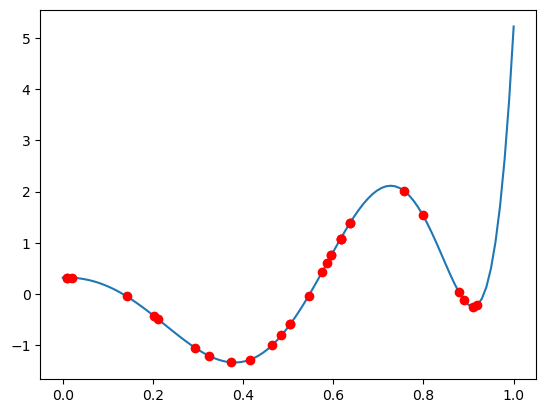

In [7]:
#Create a polynomial without noise
np.random.seed(42)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt
vals=chebys(coefs,x).ravel()
plt.plot(x,vals)

N=30
idx = np.random.randint(0,100,N)
data = vals[idx]

plt.plot(x[idx],data,'ro')

x_train = x[idx]
y_train = data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Original data creation code
np.random.seed(42)
coefs = np.random.random(11)
x = np.linspace(0, 1, 100)
vals = chebys(coefs, x).ravel()
N = 30  # Increase sample size to 30
idx = np.random.randint(0, 100, N)
data = vals[idx]

# Create a design matrix with powers of x up to degree 10
poly_degree_10 = PolynomialFeatures(degree=10)
X_train_degree_10 = poly_degree_10.fit_transform(x[idx].reshape(-1, 1))

# Create a design matrix with powers of x up to degree 3
poly_degree_3 = PolynomialFeatures(degree=3)
X_train_degree_3 = poly_degree_3.fit_transform(x[idx].reshape(-1, 1))

# Fit a linear regression model with degree 10
regression_model_degree_10 = LinearRegression()
regression_model_degree_10.fit(X_train_degree_10, data)

# Fit a linear regression model with degree 3
regression_model_degree_3 = LinearRegression()
regression_model_degree_3.fit(X_train_degree_3, data)

# Calculate in-sample RMSE for degree 10
y_pred_degree_10 = regression_model_degree_10.predict(X_train_degree_10)
in_sample_mse_degree_10 = mean_squared_error(data, y_pred_degree_10)
in_sample_rmse_degree_10 = np.sqrt(in_sample_mse_degree_10)

# Calculate in-sample RMSE for degree 3
y_pred_degree_3 = regression_model_degree_3.predict(X_train_degree_3)
in_sample_mse_degree_3 = mean_squared_error(data, y_pred_degree_3)
in_sample_rmse_degree_3 = np.sqrt(in_sample_mse_degree_3)

# Generate 100 uniform out-of-sample data points
x_out_of_sample = np.linspace(0, 1, 100)

# Create design matrices for out-of-sample points
X_out_of_sample_degree_10 = poly_degree_10.transform(x_out_of_sample.reshape(-1, 1))
X_out_of_sample_degree_3 = poly_degree_3.transform(x_out_of_sample.reshape(-1, 1))

# Calculate out-of-sample predictions for degree 10
y_out_of_sample_degree_10 = regression_model_degree_10.predict(X_out_of_sample_degree_10)

# Calculate out-of-sample predictions for degree 3
y_out_of_sample_degree_3 = regression_model_degree_3.predict(X_out_of_sample_degree_3)

# Calculate the out-of-sample RMSE for degree 10
out_of_sample_data = chebys(coefs, x_out_of_sample).ravel()
out_of_sample_mse_degree_10 = mean_squared_error(out_of_sample_data, y_out_of_sample_degree_10)
out_of_sample_rmse_degree_10 = np.sqrt(out_of_sample_mse_degree_10)

# Calculate the out-of-sample RMSE for degree 3
out_of_sample_mse_degree_3 = mean_squared_error(out_of_sample_data, y_out_of_sample_degree_3)
out_of_sample_rmse_degree_3 = np.sqrt(out_of_sample_mse_degree_3)

# Print RMSE values
print("In-sample RMSE for degree 10:", in_sample_rmse_degree_10)
print("In-sample RMSE for degree 3:", in_sample_rmse_degree_3)
print("Out-of-sample RMSE for degree 10:", out_of_sample_rmse_degree_10)
print("Out-of-sample RMSE for degree 3:", out_of_sample_rmse_degree_3)

In-sample RMSE for degree 10: 1.5754214331998496e-14
In-sample RMSE for degree 3: 0.501267604675499
Out-of-sample RMSE for degree 10: 5.359388206068496e-14
Out-of-sample RMSE for degree 3: 1.1745320508256165


**TAKE HOME IDEA:** Independently of the data generation process generating we have to match the data complexity and not the true model complexity.

# Introduction to learning curves

Let us try to see what is going on with a classification example:

In [9]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn import neighbors

MAXC=50
MAXN=1000
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
perm = np.random.permutation(y.size)
X = X[perm,:]
y = y[perm]


def complexity_number(C,N):
    
    Xr=X[:N,:]
    yr=y[:N]
    idxplus = yr==1
    idxminus = yr==-1
    idxplus = idxplus.flatten()
    idxminus = idxminus.flatten()
    plt.scatter(Xr[idxplus,0],Xr[idxplus,1],color='r')
    plt.scatter(Xr[idxminus,0],Xr[idxminus,1],color='b')   
    delta = 0.05
    xx = np.arange(-5.0, 15.0, delta)
    yy = np.arange(-5.0, 15.0, delta)
    XX, YY = np.meshgrid(xx, yy)
    Xf = XX.flatten()
    Yf = YY.flatten()
    sz=XX.shape
    data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);
    #Evaluate the model for a given weight
    clf = neighbors.KNeighborsClassifier(MAXC-C+1)
    clf.fit(Xr,yr.ravel())
    Z=clf.predict(data)
    Z.shape=sz
    plt.scatter(Xr[idxplus,0],Xr[idxplus,1],color='r')
    plt.scatter(Xr[idxminus,0],Xr[idxminus,1],color='b')
    plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
    plt.contour(XX,YY,Z,[0])
    fig = plt.gcf()
    fig.set_size_inches(9,9)
   
#Ipython 2.0
interact(complexity_number,  C=(1,MAXC), N = (20,MAXN));
#Ipython 1.1.
#C=1 #1...50
#N = 20 #20...1000
#complexity_number(C,N)

interactive(children=(IntSlider(value=25, description='C', max=50, min=1), IntSlider(value=510, description='N…

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** 
<li> Set the number of data samples per cluster $N$ to $100$ and the complexity value $C$ to $50$. Describe what you observe: Does the method missclassify any data sample? 
<li> Decrease the complexity value to $C = 20$. Describe the boundary: Does the method missclassify any data sample?
<li> Which of the two settings do you think will perform the best in front of new data from the same distribution? Why?
<li> Increase the number of data points to $N = 1000$ with $C=50$. Describe what you observe. Will the method perform better than the same method with $N=100$?
</div>

Let us visualize the behavior observed. For this purpose we may draw a curve of the training error and test error as the number of training data increases for a given complexity. This curve is called **learning curve**.

Text(0, 0.5, 'Error rate')

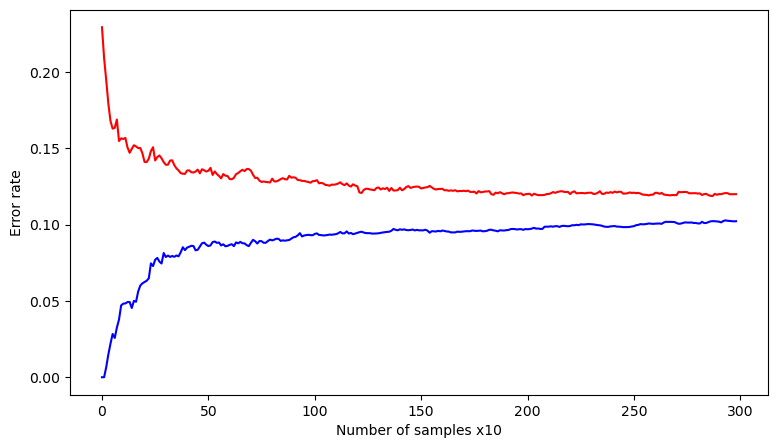

In [10]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn import metrics
from sklearn import tree

C=5
MAXN=1000

yhat_test=np.zeros((10,299,2))
yhat_train=np.zeros((10,299,2))
#Repeat ten times to get smooth curves
for i in range(10):
    X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
    y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y = np.concatenate([y,np.ones((MAXN,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(MAXN,2)])
    y_test = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y_test = np.concatenate([y_test,np.ones((MAXN,1))])
    j=0
    for N in range(10,3000,10):
        Xr=X[:N,:]
        yr=y[:N]
        idxplus = yr==1
        idxminus = yr==-1
        idxplus = idxplus.flatten()
        idxminus = idxminus.flatten()
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(Xr,yr.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,0] = 1. - metrics.accuracy_score(clf.predict(Xr), yr.ravel())
        j=j+1

plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'r')
plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(9,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')

Observing the former plot we can see:

+ As the number of training samples increase both errors tends to the same value, **bias**.
+ When we have a little amount of training data, training error is very small but test error is very large.

Check now the learning curve when the complexity is smaller.

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE** 
Repeat the exercise with C = 1.
</div>

Text(0, 0.5, 'Error rate')

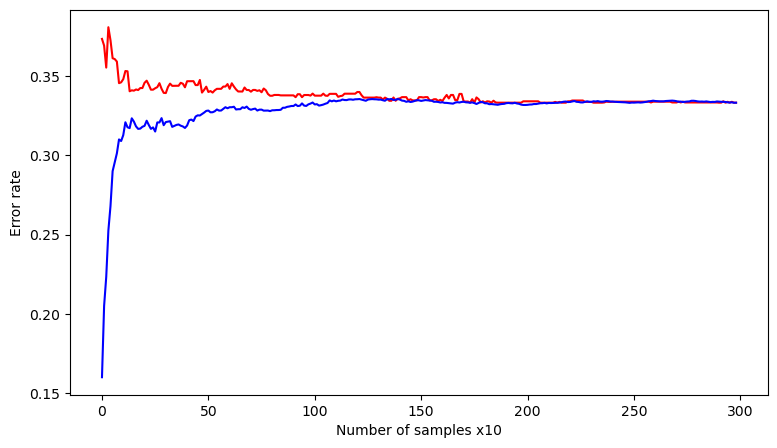

In [11]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn import metrics
from sklearn import tree

C=1
MAXN=1000

yhat_test=np.zeros((10,299,2))
yhat_train=np.zeros((10,299,2))
#Repeat ten times to get smooth curves
for i in range(10):
    X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
    y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y = np.concatenate([y,np.ones((MAXN,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(MAXN,2)])
    y_test = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
    y_test = np.concatenate([y_test,np.ones((MAXN,1))])
    j=0
    for N in range(10,3000,10):
        Xr=X[:N,:]
        yr=y[:N]
        idxplus = yr==1
        idxminus = yr==-1
        idxplus = idxplus.flatten()
        idxminus = idxminus.flatten()
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(Xr,yr.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,0] = 1. - metrics.accuracy_score(clf.predict(Xr), yr.ravel())
        j=j+1

plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'r')
plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(9,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')

We can see a similar behavior in this second curve. Let us compare the two plots.

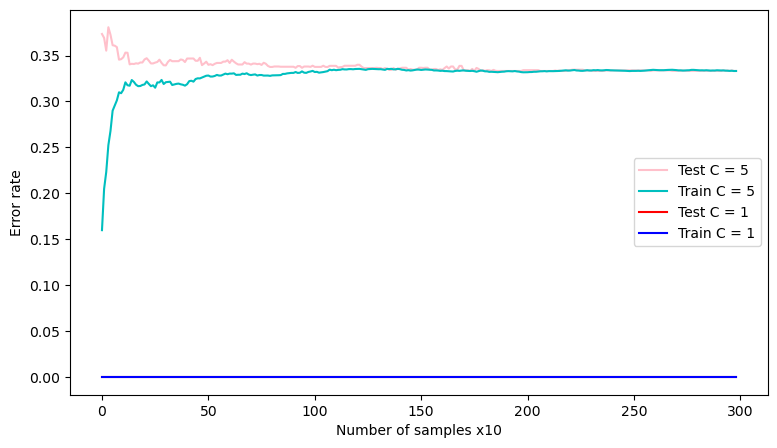

In [12]:
p1,=plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),color='pink')
p2,=plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'c')
p3,=plt.plot(np.mean(yhat_test[:,:,1].T,axis=1),'r')
p4,=plt.plot(np.mean(yhat_train[:,:,1].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(9,5)
plt.xlabel('Number of samples x10')
plt.ylabel('Error rate')
plt.legend([p1,p2,p3,p4],["Test C = 5","Train C = 5","Test C = 1","Train C = 1"])

Although both show a similar behavior we note several differences:

+ With small complexity training and test errors converge sooner/with a smaller amount of data.
+ However, with small complexity, the error of converge is larger than with increased complexity.

>The value towards both errors converge is also called **bias**, and the difference between this value and the test error is called **variance**. The **bias/variance** decomposition of the learning curve is an alternative view to the training and generalization view.

In the regression setting we can easily characterize the **bias/variance** decomposition. Consider our target function $g(x)$, and the observed data $y = g(x) + \eta$, where $\eta$ is a random variable representing noise with $\mathbb{E}[\eta] = 0$. Then we want to characterize the expected squared error

$$\mathbb{E}_{\mathcal{D},x}[(y-f(x))^2]$$

We may decompose this as follows:

$$\mathbb{E}_{\mathcal{D},x}[(y-f(x))^2] = \mathbb{E}_{\mathcal{D},x}[(g(x)+\eta-f(x))^2]
$$

we can now add and substract the hypothesis mean $\bar{f(x)}$,
$$= \mathbb{E}_{\mathcal{D},x}[(g(x)-\bar{f(x)}+ \bar{f(x)}+\eta-f(x))^2] = 
$$

Rearranging terms we have,
$$= \mathbb{E}_{\mathcal{D},x}[((g(x)-\bar{f(x)})+ (\bar{f(x)}-f(x)) +\eta)^2] = 
$$
$$= \mathbb{E}_{\mathcal{D},x}[(g(x)-\bar{f(x)})^2+ (\bar{f(x)}-f(x))^2 +\eta^2 + \text{cross terms}] = 
$$

All cross and single terms are zero (**you can check this at home and deliver the proof**)

$$= \underset{bias^2}{\underbrace{\mathbb{E}_{\mathcal{D},x}[(g(x)-\bar{f(x)})^2]}}+ \underset{variance}{\underbrace{\mathbb{E}_{\mathcal{D},x}[(\bar{f(x)}-f(x))^2]}} + \underset{stochastic noise}{\underbrace{\mathbb{E}_{\mathcal{D},x}[\eta^2]}}
$$


# Overfitting

Let us now plot the learning behavior for a fixed number of examples with respect to the complexity of the model.

<div class = "alert alert-success">**QUESTION: ** What do you expect to happen?
</div>

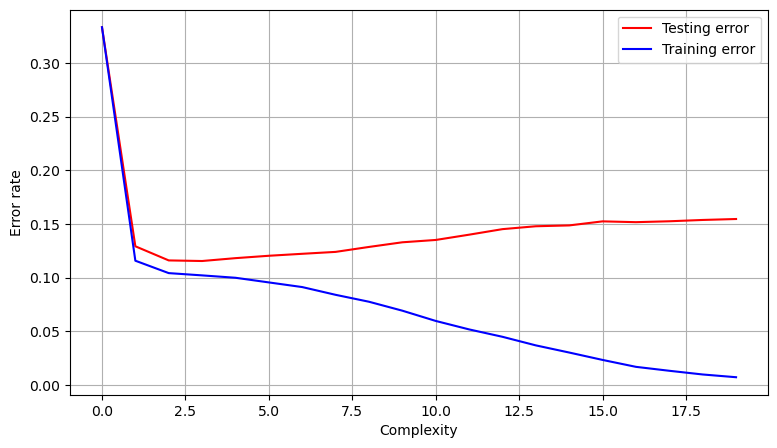

In [13]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree

MAXC=20
N=1000
NTEST=4000
ITERS=3

yhat_test=np.zeros((ITERS,MAXC,2))
yhat_train=np.zeros((ITERS,MAXC,2))
#Repeat ten times to get smooth curves
for i in range(ITERS):
    X = np.concatenate([1.25*np.random.randn(N,2),5+1.5*np.random.randn(N,2)]) 
    X = np.concatenate([X,[8,5]+1.5*np.random.randn(N,2)])
    y = np.concatenate([np.ones((N,1)),-np.ones((N,1))])
    y = np.concatenate([y,np.ones((N,1))])
    perm = np.random.permutation(y.size)
    X = X[perm,:]
    y = y[perm]

    X_test = np.concatenate([1.25*np.random.randn(NTEST,2),5+1.5*np.random.randn(NTEST,2)]) 
    X_test = np.concatenate([X_test,[8,5]+1.5*np.random.randn(NTEST,2)])
    y_test = np.concatenate([np.ones((NTEST,1)),-np.ones((NTEST,1))])
    y_test = np.concatenate([y_test,np.ones((NTEST,1))])
    
    idxplus = y==1
    idxminus = y==-1
    idxplus = idxplus.flatten()
    idxminus = idxminus.flatten()
    j=0
    for C in range(1,MAXC+1):
        #Evaluate the model
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(X,y.ravel())
        yhat_test[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        yhat_train[i,j,0] = 1. - metrics.accuracy_score(clf.predict(X), y.ravel())
        j=j+1

p1, = plt.plot(np.mean(yhat_test[:,:,0].T,axis=1),'r')
p2, = plt.plot(np.mean(yhat_train[:,:,0].T,axis=1),'b')
fig = plt.gcf()
fig.set_size_inches(9,5)
plt.xlabel('Complexity')
plt.ylabel('Error rate')
plt.legend([p1, p2], ["Testing error", "Training error"])
plt.grid(True)

Observe that as the complexity increases the training error is reduced but above a certain complexity level the test error increases. This effect is called **overfitting**.

# 4. Cures to overfitting.


The reasoning on how to cure overfitting comes from the very well known bound
$$E_{out}\leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

We want to control the out-of-sample error, thus we have a couple of routes to take:

1. Either we simulate the out-of-sample error and check against unseen data. This is working directly with the left hand side of the inequality. We can do this using **cross-validation**.
2. We change the learning objective to take into account and minimize the complexity of the model. We mimick the right hand side of the inequality and add to the objective function a term penalizing complexity. This is called **regularization**.

3. We can use **ensemble techniques**. Implicitly this strategy is similar to the complexity control technique.